In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV

In [2]:
# Load data
df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Data/top40_cell_cycle.csv")

#df['phase'] = df['phase'].replace({'M': 'G2'})

# Separate features and target
X = df.drop(columns=['phase', 'age'])  # exclude phase and age
y = df['age']  # target is now age

In [3]:
# Split data into train and test sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=949)

# Train Random Forest Regressor with 500 trees and max depth 15
rf = RandomForestRegressor(n_estimators=500, max_depth=50, max_features='sqrt', random_state=949)


In [ ]:
## hypertuning

param_grid = {
    'n_estimators': [700, 800, 900]
    #'max_depth': [50, 60]         
}

# Set up GridSearch with 10-fold cross-validation optimizing for accuracy
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,
    scoring= 'neg_root_mean_squared_error',
    n_jobs=-1
)

# Fit the model to your data
grid_search.fit(X_train, y_train)

#Output best settings and best accuracy
print("Best parameters:", grid_search.best_params_)


Best parameters: {'n_estimators': 700}


In [7]:
# OOB error 
# Define the values of max_features to test
max_features_options = [20, 25]  # Try 3–5 reasonable values

oob_results = {}

# Loop over different max_features
for mf in max_features_options:
    rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=50,
        max_features=mf,
        oob_score=True,
        bootstrap=True,
        random_state=949,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    oob_results[mf] = root_mean_squared_error(y_train, rf.oob_prediction_)

# Show OOB results
print("=== OOB Scores by max_features ===")
for mf, score in oob_results.items():
    print(f"max_features={mf}: OOB Accuracy = {score:.4f}")

# Choose best setting
best_mf = max(oob_results, key=oob_results.get)
print(f"\nBest max_features based on OOB: {best_mf}")

=== OOB Scores by max_features ===
max_features=20: OOB Accuracy = 1.2115
max_features=25: OOB Accuracy = 1.2015

Best max_features based on OOB: 20


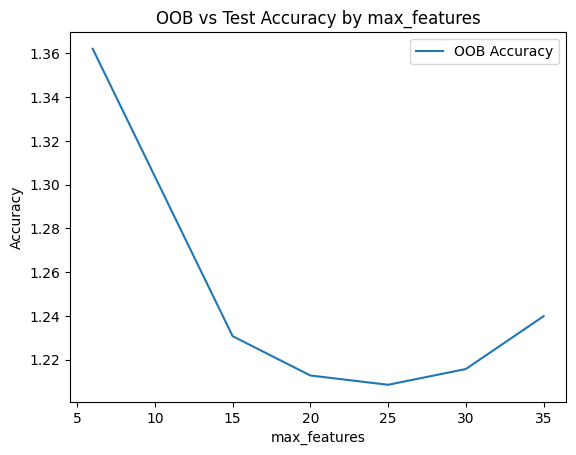

In [15]:
max_features_range = [6,15,20,25,30, 35]
oob_scores = []

for mf in max_features_range:
    rf = RandomForestRegressor(
        n_estimators=600,
        max_depth=50,
        max_features=mf,
        oob_score=True,
        random_state=42,
        bootstrap=True
    )
    rf.fit(X_train, y_train)
    
    oob_scores.append(root_mean_squared_error(y_train, rf.oob_prediction_))

plt.plot(max_features_range, oob_scores, label="OOB Accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.title("OOB vs Test Accuracy by max_features")
plt.legend()
plt.show()

In [8]:
#retrain
rf = RandomForestRegressor(n_estimators=700, max_depth=50, max_features=25, random_state=949)

rf.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [9]:
# Calculate RMSE
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

print("=== Training Set ===")
print(f"RMSE: {rmse_train:.4f}")

print("\n=== Test Set ===")
print(f"RMSE: {rmse_test:.4f}")


# For training set
df_train = pd.DataFrame({
    'true_age': y_train,
    'pred_age': y_train_pred,
    'phase': df.loc[y_train.index, 'phase']  # get phase for train samples
})

rmse_per_phase_train = df_train.groupby('phase').apply(
    lambda x: np.sqrt(mean_squared_error(x['true_age'], x['pred_age']))
)

print("RMSE per phase (Train):")
print(rmse_per_phase_train)

# For test set
df_test = pd.DataFrame({
    'true_age': y_test,
    'pred_age': y_test_pred,
    'phase': df.loc[y_test.index, 'phase']  # get phase for test samples
})

rmse_per_phase_test = df_test.groupby('phase').apply(
    lambda x: np.sqrt(mean_squared_error(x['true_age'], x['pred_age']))
)

print("\nRMSE per phase (Test):")
print(rmse_per_phase_test)


=== Training Set ===
RMSE: 0.4432

=== Test Set ===
RMSE: 1.2911
RMSE per phase (Train):
phase
G0    0.455612
G1    0.370990
G2    0.431786
M     1.517580
S     0.474046
dtype: float64

RMSE per phase (Test):
phase
G0    1.398253
G1    1.071631
G2    1.392073
M     2.521155
S     1.372165
dtype: float64


/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_1770/1446578971.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_train = df_train.groupby('phase').apply(
/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_1770/1446578971.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_test = df_test.groupby('phase').apply(


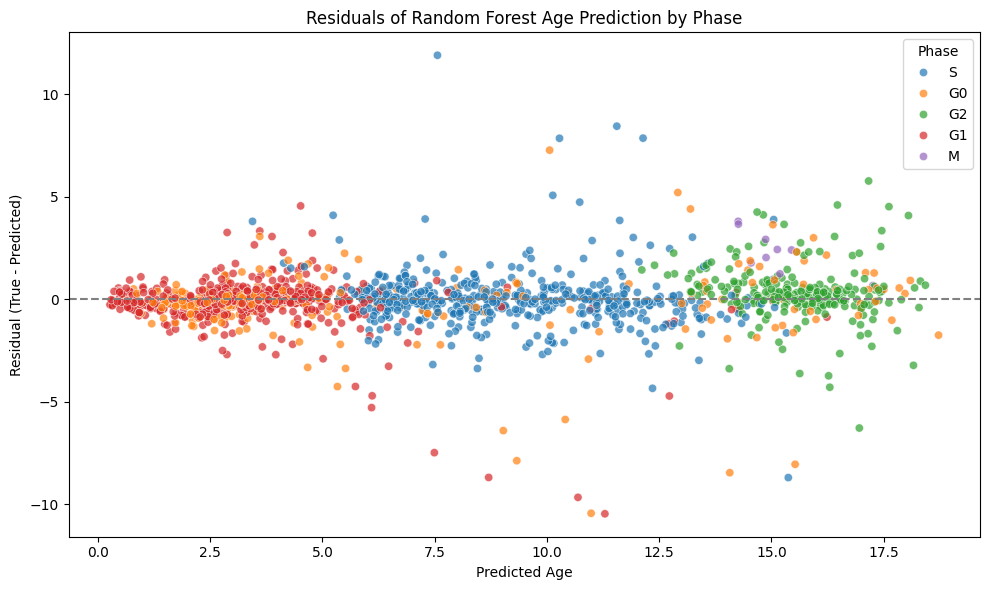

In [10]:
## PLOT RESIDUALS
# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'True Age': y_test,
    'Predicted Age': y_test_pred,
    'Residual': y_test - y_test_pred,
    'Phase': df.loc[y_test.index, 'phase']
})

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x='Predicted Age',
    y='Residual',
    hue='Phase',
    palette='tab10',
    alpha=0.7
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals of Random Forest Age Prediction by Phase")
plt.xlabel("Predicted Age")
plt.ylabel("Residual (True - Predicted)")
plt.legend(title='Phase')
plt.tight_layout()
# Save the plot
plot_path = "rf_regression_top40.png"
plt.savefig(plot_path, dpi=300)
plt.show()

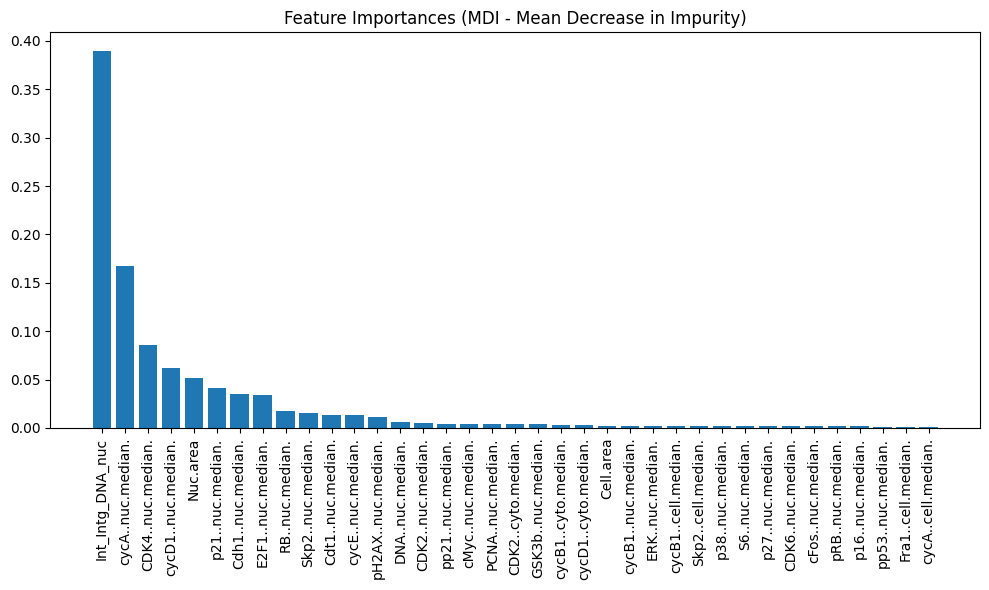

                Feature  MDI Importance
4      Int_Intg_DNA_nuc        0.389433
1     cycA..nuc.median.        0.167413
24    CDK4..nuc.median.        0.086202
2    cycD1..nuc.median.        0.061543
7              Nuc.area        0.051571
3      p21..nuc.median.        0.041077
8     Cdh1..nuc.median.        0.034667
0     E2F1..nuc.median.        0.033670
13      RB..nuc.median.        0.017671
5     Skp2..nuc.median.        0.015436
6     Cdt1..nuc.median.        0.013237
9     cycE..nuc.median.        0.012830
11   pH2AX..nuc.median.        0.011784
25     DNA..nuc.median.        0.006190
23    CDK2..nuc.median.        0.004559
22    pp21..nuc.median.        0.004147
12    cMyc..nuc.median.        0.003947
10    PCNA..nuc.median.        0.003713
34   CDK2..cyto.median.        0.003637
32   GSK3b..nuc.median.        0.003562
15  cycB1..cyto.median.        0.003126
31  cycD1..cyto.median.        0.002587
27            Cell.area        0.002470
17   cycB1..nuc.median.        0.002405


In [13]:
# Get feature importances (MDI)
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]  # Sort by importance descending

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (MDI - Mean Decrease in Impurity)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'MDI Importance': importances
}).sort_values(by='MDI Importance', ascending=False)

print(importance_df)